# The Organoid Profiler 

In order to run this notebook yourself, make sure to follow the instruction in the readme file to have all the required library correctly installed.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from orgprofiler.segmentation import build_segmentation_mask_fiji_style, build_segmentation_mask_cpsam
from orgprofiler.imaging import convert_rgb_to_grayscale_uint8
from orgprofiler.analysis import analyze_image

# Set up plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.cmap'] = 'gray'

## 1. Load Sample Image

We'll use a sample brightfield image from the dataset.

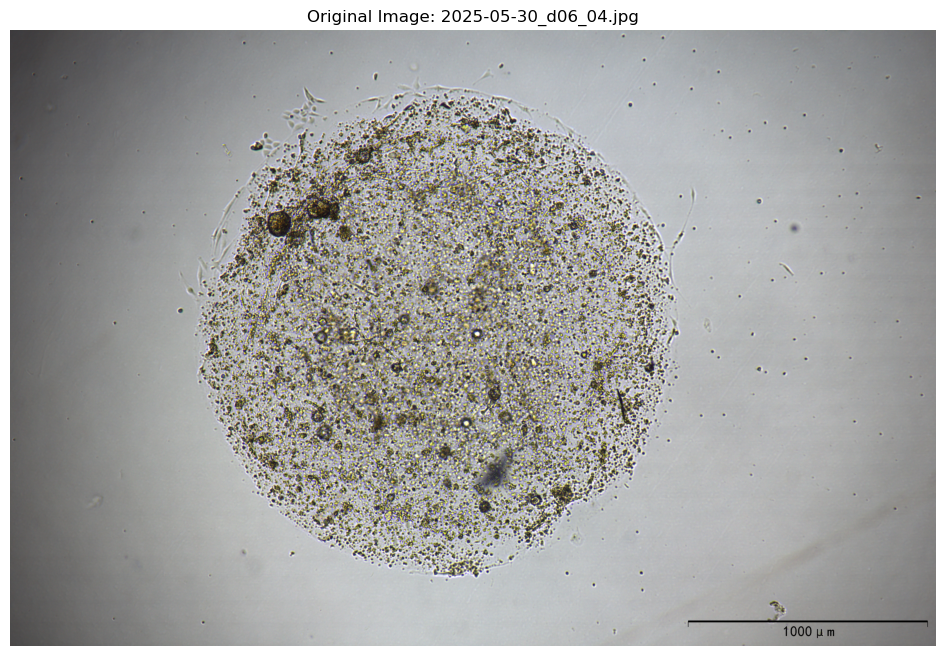

In [2]:
IMAGE_PATH = "dataset/2025-05-30_d06_04.jpg"

if not os.path.exists(IMAGE_PATH):
    print(f"Image not found at {IMAGE_PATH}. Please check the path.")
else:
    img = Image.open(IMAGE_PATH).convert("RGB")
    img_array = np.array(img)
    
    plt.imshow(img_array)
    plt.title(f"Original Image: {os.path.basename(IMAGE_PATH)}")
    plt.axis('off')
    plt.show()

## 2. Option A: Fiji-inspired Segmentation

This method uses `skimage` filters and morphological operations to create a binary mask.

Running Fiji-style segmentation...


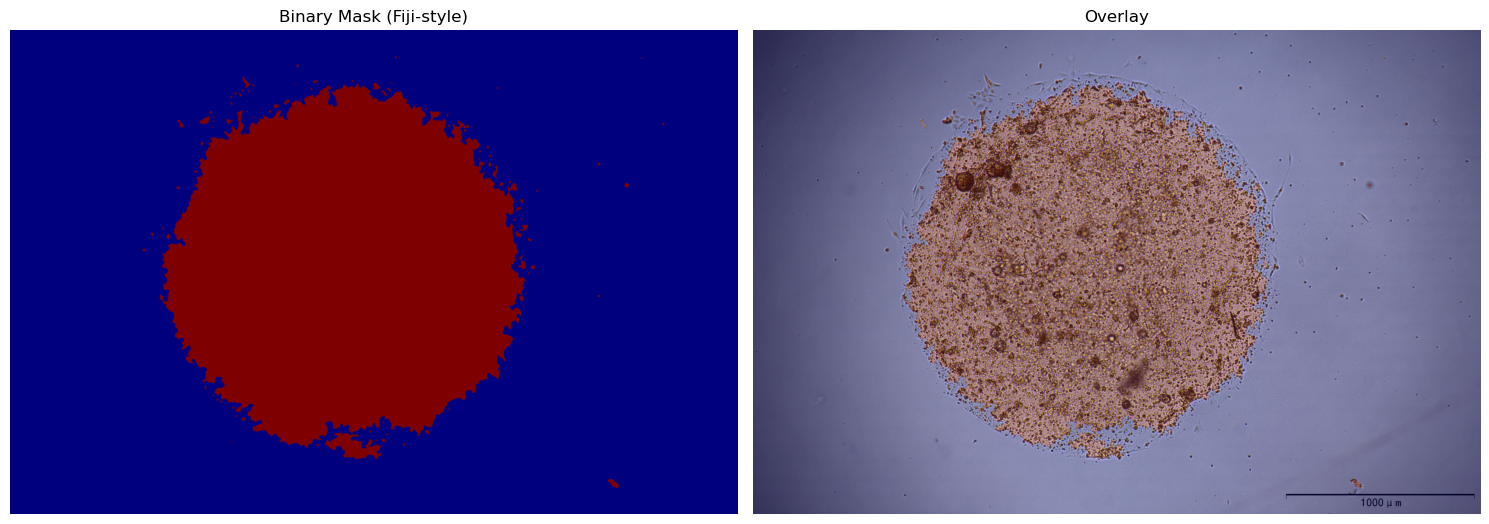

In [3]:
fiji_params = {
    "gaussian_sigma": 6.4,
    "dilation_iterations": 4,
    "erosion_iterations": 5,
    "clear_border_artifacts": True,
    "object_is_dark": True
}

print("Running Fiji-style segmentation...")
fiji_mask = build_segmentation_mask_fiji_style(img_array, **fiji_params)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(fiji_mask, cmap='jet')
axes[0].set_title("Binary Mask (Fiji-style)")
axes[0].axis('off')

axes[1].imshow(img_array)
axes[1].imshow(fiji_mask, alpha=0.3, cmap='jet')
axes[1].set_title("Overlay")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Option B: Cellpose Segmentation

This method used a fine-tuned `cpsam` model from Cellpose. 


Running Cellpose cpsam segmentation...


2025-12-21 19:13:34.121 | INFO     | orgprofiler.segmentation:build_segmentation_mask_cpsam:92 - Evaluating organoid cpsam...
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


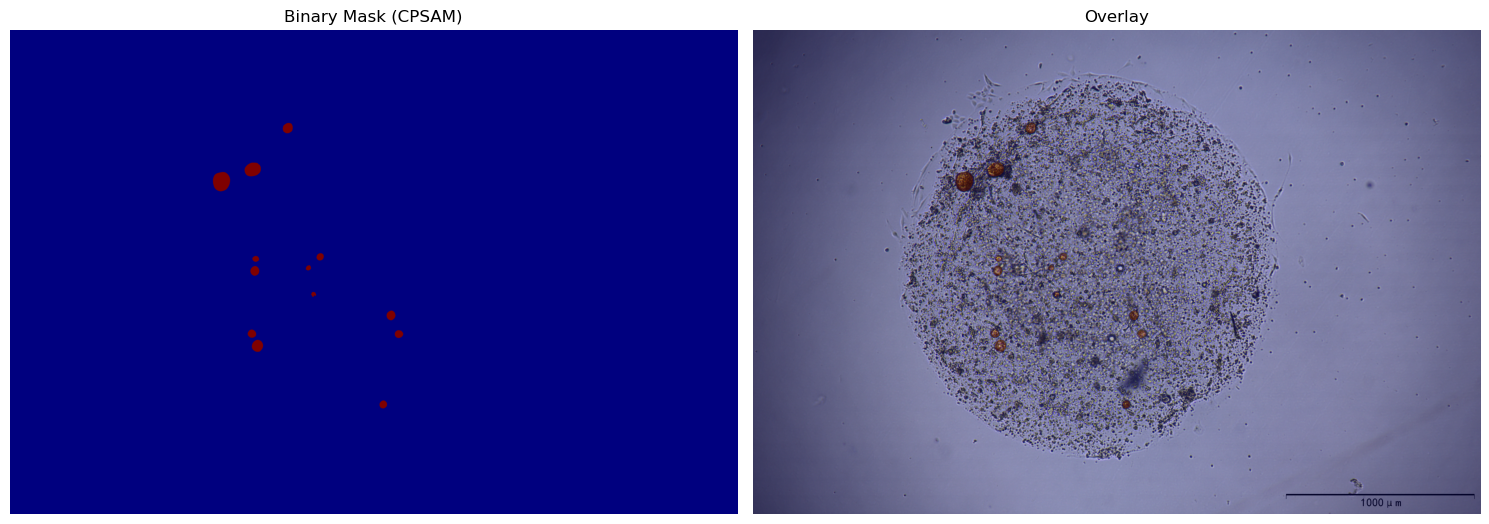

In [5]:
cpsam_params = {
    "diameter": 80,  # Auto-estimate
    "flow_threshold": 0.4,
    "cellprob_threshold": 0.4,
    "min_size": 80,
    "clear_border_artifacts": True,
    "pretrained_model": "organoid_cpsam"
}

try:
    print("Running Cellpose cpsam segmentation...")
    cellpose_mask = build_segmentation_mask_cpsam(img_array, **cpsam_params)
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(cellpose_mask, cmap='jet')
    axes[0].set_title("Binary Mask (CPSAM)")
    axes[0].axis('off')

    axes[1].imshow(img_array)
    axes[1].imshow(cellpose_mask, alpha=0.3, cmap='jet')
    axes[1].set_title("Overlay")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
except RuntimeError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

## 4. Analysis and Metrics

Once we have a mask, we can calculate various morphological and intensity metrics using the `analyze_image` function.

In [6]:
# Example of running the full analysis pipeline with default brightfield parameters
analysis_params = {
    "sigma_pre": 6.4,
    "dilate_iter": 4,
    "erode_iter": 5,
    "min_area_px": 60000,
    "max_area_px": 20000000,
    "min_circ": 0.28,
    "edge_margin": 0.20,
    "pixel_size_um": 0.86,
    "overlay_width": 11,
    "return_images": True,
    "crop_overlay": False,
    "crop_border_px": 2,
    "ring_px": 20,
    "invert_for_intensity": True,
    "exclude_edge_particles": True,
    "select_strategy": "largest",
    "area_filter_px": None,
    "background_mode": "ring",
    "object_is_dark": True
}

results = analyze_image(img_array, **analysis_params)

print("--- Analysis Results ---")
for key, value in results['results'].items():
    if isinstance(value, float):
        print(f"{key:20}: {value:.4f}")
    else:
        print(f"{key:20}: {value}")

2025-12-21 19:14:25.053 | INFO     | orgprofiler.profiling:time_block:32 - [TIMER] segmentation: 2.474s


--- Analysis Results ---
area                : 4052717.3372
mean                : 109.1726
stdDev              : 50.6824
mode                : 75.0000
min                 : 0.0000
max                 : 242.0000
x                   : 2162.0353
y                   : 1549.3787
xm                  : 2144.4690
ym                  : 1541.3383
perim               : 15000.2810
bx                  : 982.1200
by                  : 353.4600
width               : 2354.6800
height              : 2427.7800
major               : 2290.5813
minor               : 2268.4100
angle               : -55.7393
circ                : 0.2263
feret               : 2439.8727
intDen              : 598222912.0000
median              : 104.0000
skew                : -0.2816
kurt                : -0.6466
rawIntDen           : 598222912.0000
feretX              : 2061.4200
feretY              : 360.7700
feretAngle          : 82.6896
minFeret            : 2325.9421
ar                  : 1.0098
round               : 0.983